In [1]:
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
# Super Resolution model definition in PyTorch
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt
%matplotlib inline


class SuperResolutionNet(nn.Module):
    def __init__(self, upscale_factor, inplace=False):
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

# Create the super-resolution model by using the above model definition.
torch_model = SuperResolutionNet(upscale_factor=3)

In [2]:
# Load pretrained model weights
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'
batch_size = 1    # just a random number

# Initialize model with the pretrained weights
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))

# set the model to inference mode
torch_model.eval()


SuperResolutionNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

In [18]:
print(torch_model)

SuperResolutionNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)


In [3]:
# Input to the model
x = torch.randn(batch_size, 1, 224, 224, requires_grad=True)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

In [4]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("super_resolution.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")


Exported model has been tested with ONNXRuntime, and the result looks good!


In [19]:
from PIL import Image
import torchvision.transforms as transforms

img = Image.open("./NB_images/blury_bee.jpg")

resize = transforms.Resize([224, 224])
img = resize(img)
print(np.array(img).shape)

img_ycbcr = img.convert('YCbCr')
img_y, img_cb, img_cr = img_ycbcr.split()

to_tensor = transforms.ToTensor()
img_y = to_tensor(img_y)
img_y.unsqueeze_(0)
img_y.size()

(224, 224, 3)


torch.Size([1, 1, 224, 224])

In [10]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)}
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0]

In [30]:
img_out_y.shape

(1, 1, 672, 672)

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
def post_processing(img_out_y):
    img_out_y = Image.fromarray(np.uint8((img_out_y[0] * 255.0).clip(0, 255)[0]), mode='L')

    # get the output image follow post-processing step from PyTorch implementation
    final_img = Image.merge(
        "YCbCr", [
            img_out_y,
            img_cb.resize(img_out_y.size, Image.BICUBIC),
            img_cr.resize(img_out_y.size, Image.BICUBIC),
        ]).convert("RGB")
    return final_img



In [20]:
input_names=['input']
output_names=['output']
dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}

# A dummy input is needed to generate the ONNX model
# Using NCHW format
dummy_input = torch.randn(1,1,224, 224) 

# No dynamic batch dimension
torch.onnx.export(torch_model, dummy_input, "./torch_model.onnx", verbose=False, 
                  input_names=input_names, output_names=output_names)



In [21]:
import onnx
#Load the ONNX Model
model_onnx = onnx.load("./torch_model.onnx")

# # Check that the IR is well formed
onnx.checker.check_model(model_onnx)

In [26]:
import onnxruntime as ort

#ort_session = ort.InferenceSession('./ckpt/model_weights.onnx')
ort_session = ort.InferenceSession('./torch_model.onnx')


def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy().astype('float32') 
# adding .astype('float32') refer to this issue http://www.xavierdupre.fr/app/onnxruntime/helpsphinx/auto_examples/plot_common_errors.html

# compute ONNX Runtime output prediction
ort_outs = ort_session.run(None, {'input': to_numpy(img_y)})

img_out_y = ort_outs[0] # 'input is the layer name specified earlier'


(224, 224, 3) (672, 672, 3)


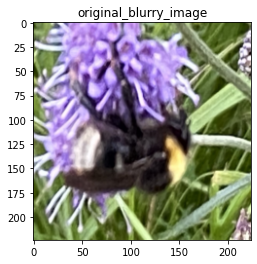

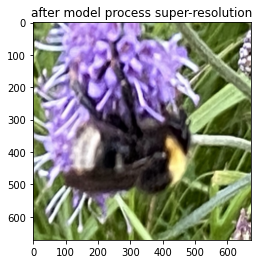

In [28]:
final_img=post_processing(img_out_y)
print(np.array(img).shape, np.array(final_img).shape)
plt.imshow(img)
plt.title("original_blurry_image")
plt.show()
plt.imshow(final_img)
plt.title("after model process super-resolution")
plt.show()

# convert to TensorRT plan file

In [29]:
import engine as eng
import argparse
from onnx import ModelProto 
import tensorrt as trt

engine_name = "./model.plan"
onnx_path = "./torch_model.onnx"
batch_size = 1 

TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_runtime = trt.Runtime(TRT_LOGGER)

model = ModelProto()
with open(onnx_path, "rb") as f:
    model.ParseFromString(f.read())

d0 = model.graph.input[0].type.tensor_type.shape.dim[1].dim_value
d1 = model.graph.input[0].type.tensor_type.shape.dim[2].dim_value
d2 = model.graph.input[0].type.tensor_type.shape.dim[3].dim_value
shape = [batch_size , d0, d1 ,d2]
engine = eng.build_engine(onnx_path, shape= shape)
eng.save_engine(engine, engine_name)

In [31]:
%%writefile ./model_repo/custom_plan2/config.pbtxt
name: "custom_plan2"
platform: "tensorrt_plan"
max_batch_size : 1
input [
  {
    name: "input"
    data_type: TYPE_FP32
    format: FORMAT_NCHW
    dims: [ 1,224,224 ]
    reshape {shape : [1,1,224,224]}
  }
]
output [
  {
    name: "output"
    data_type: TYPE_FP32
    dims: [ 1,672,672 ]
    reshape{shape:[1,1,672,672]}
  }
]
instance_group [
  {
    count: 2
    kind: KIND_GPU
  }
]
dynamic_batching {
  preferred_batch_size: [ 1 ]
}



Writing ./model_repo/custom_plan2/config.pbtxt
